In [11]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种常用的黑体中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

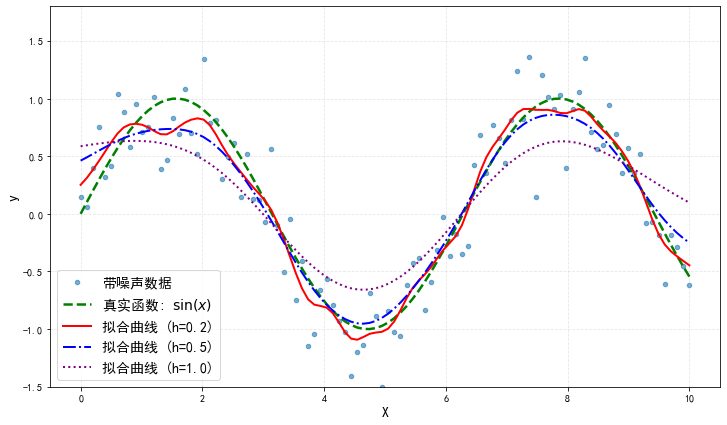

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

class KernelRegression:
    def __init__(self, bandwidth=0.5):
        self.bandwidth = bandwidth
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        return self
        
    def predict(self, X_test):
        dist_sq = cdist(self.X, X_test, 'sqeuclidean') 
        weights = np.exp(-dist_sq / (2 * self.bandwidth**2))
        weights /= np.sum(weights, axis=0, keepdims=True)
        return np.dot(weights.T, self.y)

# 生成数据
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y_true = np.sin(X).ravel()
y = y_true + np.random.normal(0, 0.3, size=100)

# 创建单一坐标系
plt.figure(figsize=(12, 7))

# 绘制原始数据和真实函数
plt.scatter(X, y, s=20, alpha=0.6, label='带噪声数据')
plt.plot(X, y_true, 'g--', lw=2.5, label='真实函数: $\sin(x)$')

# 绘制不同带宽的拟合曲线
bandwidths = [0.2, 0.5, 1.0]
colors = ['red', 'blue', 'purple']
linestyles = ['-', '-.', ':']

for h, color, ls in zip(bandwidths, colors, linestyles):
    kr = KernelRegression(bandwidth=h)
    y_pred = kr.fit(X, y).predict(X)
    plt.plot(X, y_pred, color=color, linestyle=ls, lw=2, 
             label=f'拟合曲线 (h={h})')

plt.legend(loc='lower left', fontsize=14) 
plt.xlabel('X', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis([-0.5, 10.5, -1.5, 1.8])
plt.show()

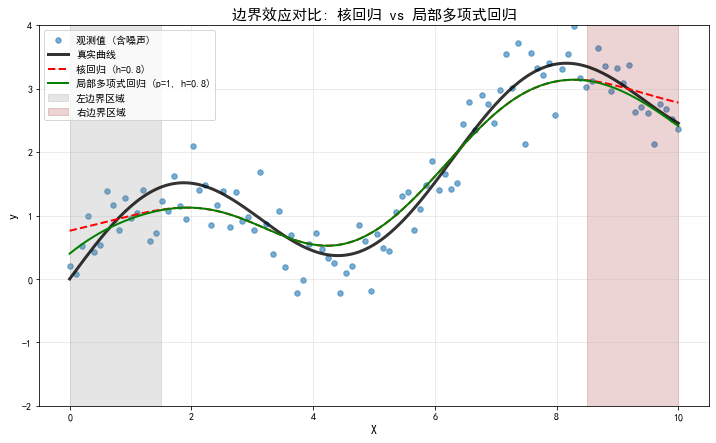

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 生成模拟数据
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y_true = np.sin(X) + 0.3 * X  # 真实函数
y = y_true + np.random.normal(0, 0.4, (100, 1))  # 添加噪声

# 定义核回归函数（高斯核）
def kernel_regression(X_train, y_train, X_test, h=0.8):
    """
    Nadaraya-Watson核回归
    :param h: 带宽，控制平滑程度
    """
    y_pred = np.zeros(len(X_test))
    for i, x0 in enumerate(X_test):
        # 计算高斯权重
        weights = np.exp(-0.5 * ((X_train - x0) / h) ** 2).flatten()
        weights /= np.sum(weights)  # 归一化
        y_pred[i] = np.dot(weights, y_train.flatten())
    return y_pred

# 定义局部多项式回归函数
def local_poly_regression(X_train, y_train, X_test, degree=1, h=0.8):
    """
    局部多项式回归（默认局部线性）
    :param degree: 多项式阶数
    :param h: 带宽
    """
    y_pred = np.zeros(len(X_test))
    for i, x0 in enumerate(X_test):
        # 计算高斯权重
        weights = np.exp(-0.5 * ((X_train - x0) / h) ** 2).flatten()
        # 构建多项式特征
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X_train - x0)  # 中心化
        # 加权最小二乘拟合
        model = LinearRegression()
        model.fit(X_poly, y_train, sample_weight=weights)
        y_pred[i] = model.predict(poly.transform([[0]]))[0]  # 预测中心点
    return y_pred

# 生成测试点（边界区域加密）
X_test = np.linspace(0, 10, 200).reshape(-1, 1)

# 计算三种拟合结果
y_true_test = np.sin(X_test) + 0.3 * X_test  # 真实曲线
y_kernel = kernel_regression(X, y, X_test, h=0.8)  # 核回归
y_local_poly = local_poly_regression(X, y, X_test, degree=1, h=0.8)  # 局部多项式回归

# 可视化对比
plt.figure(figsize=(12, 7))

# 绘制原始数据和真实曲线
plt.scatter(X, y, s=30, alpha=0.6, label='观测值 (含噪声)')
plt.plot(X_test, y_true_test, 'k-', lw=3, alpha=0.8, label='真实曲线')

# 绘制回归曲线
plt.plot(X_test, y_kernel, 'r--', lw=2, label='核回归 (h=0.8)')
plt.plot(X_test, y_local_poly, 'g-', lw=2, label='局部多项式回归 (p=1, h=0.8)')

# 标记边界区域
plt.axvspan(0, 1.5, color='gray', alpha=0.2, label='左边界区域')
plt.axvspan(8.5, 10, color='brown', alpha=0.2, label='右边界区域')

# 图表装饰
plt.title("边界效应对比: 核回归 vs 局部多项式回归", fontsize=15)
plt.xlabel("X", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.ylim(-2, 4)  # 扩展Y轴范围以显示边界差异
plt.show()

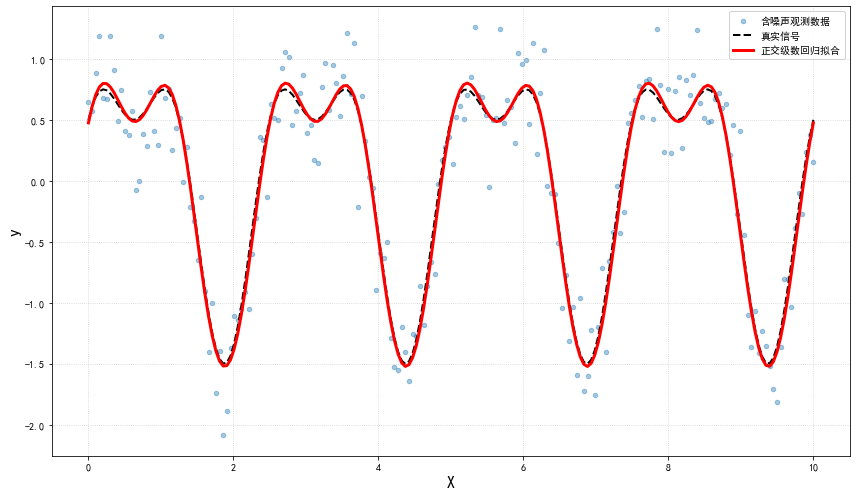

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq

# 生成周期数据
np.random.seed(42)
t = np.linspace(0, 10, 200)
T_period = 2.5  # 数据周期
y_true = np.sin(2 * np.pi / T_period * t) + 0.5 * np.cos(4 * np.pi / T_period * t)
y_noisy = y_true + 0.3 * np.random.randn(len(t))

# Fourier基函数回归
def fourier_basis(t, N, T):
    omega = 2 * np.pi / T
    X = np.ones((len(t), 2 * N + 1))
    for k in range(1, N + 1):
        X[:, 2 * k - 1] = np.cos(k * omega * t)
        X[:, 2 * k] = np.sin(k * omega * t)
    return X

# 选择最优阶数 N=3（根据实际数据调整）
X_design = fourier_basis(t, N=3, T=T_period)
coeffs, _, _, _ = lstsq(X_design, y_noisy)
y_pred = X_design @ coeffs

# 绘制结果
plt.figure(figsize=(12, 7))
plt.scatter(t, y_noisy, s=20, alpha=0.4, label='含噪声观测数据')
plt.plot(t, y_true, 'k--', lw=2, label='真实信号')
plt.plot(t, y_pred, 'r-', lw=3, label='正交级数回归拟合')
plt.xlabel('X', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(loc='upper right', framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

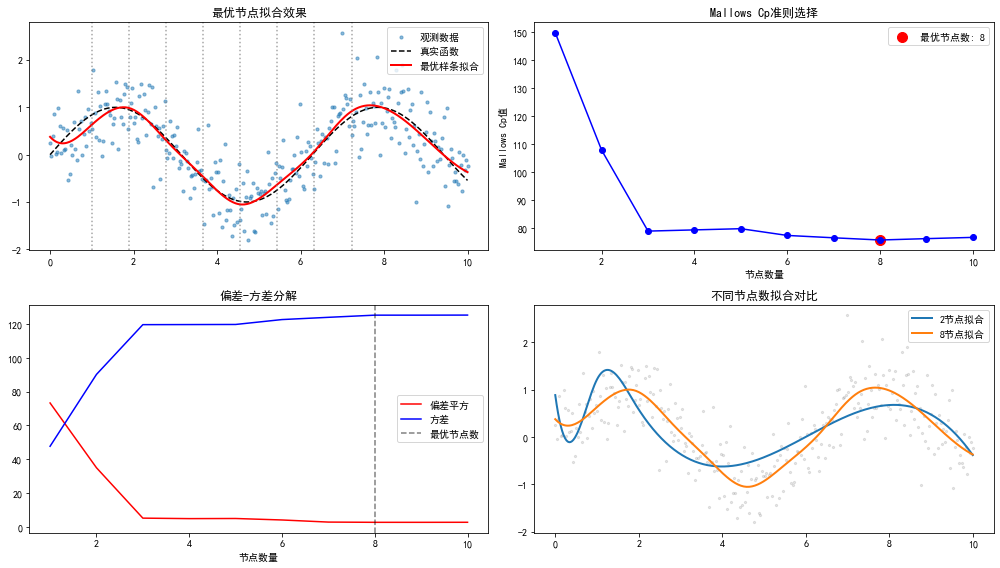

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 1. 模拟数据生成
np.random.seed(42)
x = np.linspace(0, 10, 300)
y = np.sin(x) + 0.5 * np.random.randn(300)  # 正弦函数+噪声

# 2. 截断幂基函数
def build_truncated_basis(x, knots, degree=3):
    """构建截断幂基设计矩阵"""
    # 多项式部分: 1, x, x^2, ..., x^degree
    X_poly = np.column_stack([x**d for d in range(degree+1)])
    
    # 截断幂部分: (x - t_k)^3_+ 
    X_trunc = np.zeros((len(x), len(knots)))
    for i, knot in enumerate(knots):
        X_trunc[:, i] = np.where(x > knot, (x - knot)**degree, 0)
        
    return np.hstack([X_poly, X_trunc])

# 3. 节点选择算法
def select_knots(x, y, max_knots=10, alpha=2.0):
    """实现节点删除法选择最优节点集"""
    # 3.1 初始化节点: 分位数位置
    knots = np.quantile(x, np.linspace(0.1, 0.9, max_knots))
    
    # 记录迭代历史
    history = {'knots_num': [], 'knots': [], 'cp': [], 'rss': []}
    
    # 3.2 初始完整模型
    X_full = build_truncated_basis(x, knots)
    model_full = LinearRegression().fit(X_full, y)
    rss_full = ((y - model_full.predict(X_full))**2).sum()
    sigma2_hat = rss_full / (len(y) - X_full.shape[1])  # 误差方差估计
    
    # 3.3 迭代删除节点
    current_knots = knots.copy()
    
    for step in range(max_knots):
        # 构建当前设计矩阵
        X = build_truncated_basis(x, current_knots)
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        rss = ((y - y_pred)**2).sum()
        p = X.shape[1]  # 当前参数个数
        
        # 计算Mallows Cp值
        cp_val = rss + alpha * p * sigma2_hat
        
        # 记录当前状态
        history['knots_num'].append(len(current_knots))
        history['knots'].append(current_knots.copy())
        history['cp'].append(cp_val)
        history['rss'].append(rss)
        
        # 如果已无节点，则终止
        if len(current_knots) == 0:
            break
            
        # 计算t统计量
        mse_current = rss / (len(y) - p)  # 计算当前模型的均方误差
        t_stats = []
        for i in range(len(current_knots)):
            # 使用稳健的标准差计算避免除零错误
            col_std = np.std(X[:, 4 + i])
            if col_std < 1e-8:
                t_val = 0
            else:
                # 计算标准误
                se = np.sqrt(mse_current) / col_std
                t_val = abs(model.coef_[4 + i] / se)
            t_stats.append(t_val)
        
        # 找到最小t值对应的节点索引
        idx_to_remove = np.argmin(t_stats)
        
        # 删除该节点
        current_knots = np.delete(current_knots, idx_to_remove)
    
    # 3.4 找出最优模型 (最小Cp值)
    best_idx = np.argmin(history['cp'])
    best_knots = history['knots'][best_idx]   
    return best_knots, history

# 4. 执行节点选择
best_knots, history = select_knots(x, y)

# 5. 可视化结果
plt.figure(figsize=(14, 8))

# 5.1 真实函数与拟合曲线
plt.subplot(2, 2, 1)
plt.scatter(x, y, s=10, alpha=0.5, label='观测数据')
plt.plot(x, np.sin(x), 'k--', label='真实函数')

# 最优节点拟合
X_best = build_truncated_basis(x, best_knots)
model_best = LinearRegression().fit(X_best, y)
y_best = model_best.predict(X_best)
plt.plot(x, y_best, 'r-', lw=2, label='最优样条拟合')

# 标记最优节点位置
for knot in best_knots:
    plt.axvline(knot, color='gray', linestyle=':', alpha=0.7)
    
plt.title('最优节点拟合效果')
plt.legend()

# 5.2 Mallows Cp准则变化
plt.subplot(2, 2, 2)
knots_nums = history['knots_num']
cp_values = history['cp']
best_num = len(best_knots)

plt.plot(knots_nums, cp_values, 'bo-')
plt.scatter([best_num], [min(cp_values)], color='red', s=100, 
            label=f'最优节点数: {best_num}')
plt.xlabel('节点数量')
plt.ylabel('Mallows Cp值')
plt.title('Mallows Cp准则选择')
plt.legend()

# 5.3 偏差-方差权衡展示
plt.subplot(2, 2, 3)
bias2_list = []
variance_list = []
for knots_set in history['knots']:
    X_temp = build_truncated_basis(x, knots_set)
    model_temp = LinearRegression().fit(X_temp, y)
    y_pred_temp = model_temp.predict(X_temp)
    # 偏差平方 = (预测值 - 真实函数)^2 的和
    bias2 = np.sum((y_pred_temp - np.sin(x))**2)
    # 方差 = 残差平方和 - 偏差平方
    variance = np.sum((y_pred_temp - np.mean(y_pred_temp))**2)
    bias2_list.append(bias2)
    variance_list.append(variance)

plt.plot(knots_nums, bias2_list, 'r-', label='偏差平方')
plt.plot(knots_nums, variance_list, 'b-', label='方差')
plt.axvline(best_num, color='k', linestyle='--', alpha=0.5, label='最优节点数')
plt.xlabel('节点数量')
plt.title('偏差-方差分解')
plt.legend()

# 5.4 不同节点数拟合对比
plt.subplot(2, 2, 4)
knot_nums_to_show = [2, best_num]  # 少、优节点
for num in knot_nums_to_show:
    # 找到该节点数对应的节点集
    idx = [i for i, n in enumerate(history['knots_num']) if n == num][0]
    knots_temp = history['knots'][idx]
    
    X_temp = build_truncated_basis(x, knots_temp)
    model_temp = LinearRegression().fit(X_temp, y)
    y_temp = model_temp.predict(X_temp)
    
    plt.plot(x, y_temp, lw=2, label=f'{num}节点拟合')

plt.scatter(x, y, s=5, alpha=0.2, c='gray')
plt.title('不同节点数拟合对比')
plt.legend()

plt.tight_layout()
plt.show()

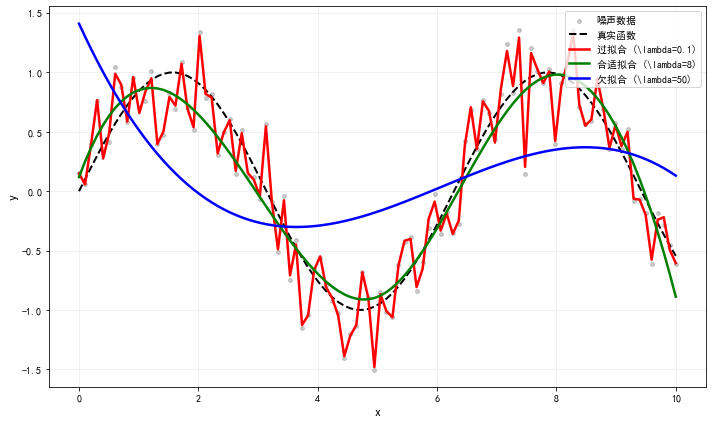

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# 生成带噪声的正弦数据
np.random.seed(42)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.3, len(x))

# 准备三种光滑参数：过拟合(\lambda=0.1)、合适拟合(\lambda=8)、欠拟合(\lambda=50)
smoothing_params = [0.1, 8, 50]  
colors = ['red', 'green', 'blue']
labels = ['过拟合 (\lambda=0.1)', '合适拟合 (\lambda=8)', '欠拟合 (\lambda=50)']

# 创建画布
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=15, alpha=0.4, label='噪声数据', color='gray')
plt.plot(x, np.sin(x), 'k--', lw=2, label='真实函数')

# 遍历不同\lambda值并拟合
for s_val, color, label in zip(smoothing_params, colors, labels):
    spline = UnivariateSpline(x, y, s=s_val)
    y_smooth = spline(x)
    plt.plot(x, y_smooth, lw=2.5, color=color, label=label)

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

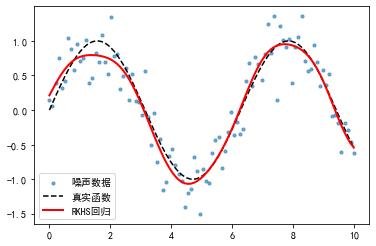

In [15]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF

# 生成示例数据
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X).ravel() + np.random.normal(0, 0.3, len(X))

# 定义RKHS模型（高斯核）
kernel = RBF(length_scale=1.0)  # 核函数
model = KernelRidge(alpha=0.1, kernel=kernel)  # alpha为正则化参数λ

# 训练与预测
model.fit(X, y)
y_pred = model.predict(X)

# 可视化
import matplotlib.pyplot as plt
plt.scatter(X, y, s=10, alpha=0.6, label='噪声数据')
plt.plot(X, np.sin(X), 'k--', label='真实函数')
plt.plot(X, y_pred, 'r-', lw=2, label='RKHS回归')

plt.legend()
plt.show()